In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import matplotlib

%matplotlib inline

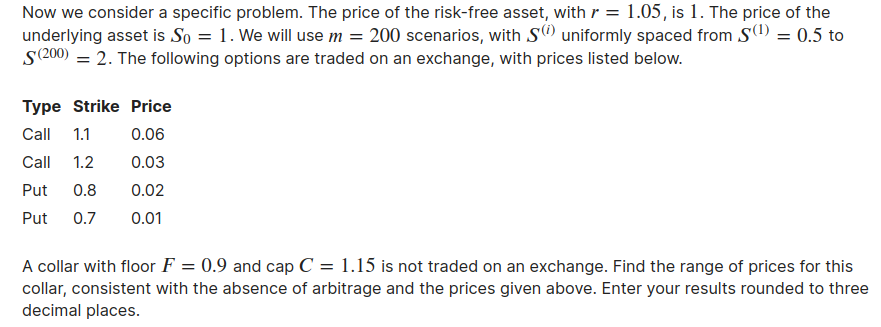

$V_{i,j}$ = value of asset j in scenario i

---

Non-abitrage condition:  
$\nexists x | Vx \geq 0 \land p^Tx < 0$

Iff (Farka's Lemma):

$\exists y \geq 0 | V^Ty = p$

---





In [2]:
r = 1.05
s0 = 1
m = 200
S = np.linspace(0.5,2,m)

options = [('call', 1.1, 0.06), 
           ('call', 1.2, 0.03),
           ('put', 0.8, 0.02),
           ('put', 0.7, 0.01),
          ]

collar_F = 0.9
collar_C = 1.15

def collar_payoff(S, s0, F, C):
    return np.clip(S, F, C) - s0

def option_payoff(t, S, K):
    if t == 'put':
        return np.clip(K-S, 0, None)
    elif t == 'call':
        return np.clip(S-K, 0, None)
    else:
        raise(ValueError(f"invalid type: {t}"))

In [3]:
# building V

# risk free
V = np.full((m,1), r)
# stock
V = np.hstack((V, S.reshape((-1,1))))
# options
for t, K, _ in options:
    payoff = option_payoff(t,S,K).reshape(-1,1)
    V = np.hstack((V, payoff))

# collar
payoff = collar_payoff(S, s0, collar_F, collar_C).reshape(-1,1)
V = np.hstack((V, payoff))

print('V shape:', V.shape)

V shape: (200, 7)


In [4]:
# price vector
p = np.array([1, 1] + [opt[2] for opt in options]).reshape(-1,1)
print('price vector: ', p)

price vector:  [[1.  ]
 [1.  ]
 [0.06]
 [0.03]
 [0.02]
 [0.01]]


# LP formulation

In [6]:
# variables
y = cp.Variable((m,1))
p_collar = cp.Variable(name = 'collar price')

constraints = [
    V.T[:-1] @ y == p, 
    V.T[-1:] @ y == p_collar,
    y >= 0, 
]

for t in ['lower', 'upper']:
    obj = cp.Maximize if t == 'upper' else cp.Minimize
    prob = cp.Problem(obj(p_collar), constraints = constraints)
    prob.solve()
    assert prob.status == cp.OPTIMAL
    print(f'{t} bound', round(float(p_collar.value),3) , f'({p_collar.value})')



lower bound 0.033 (0.032619047619008155)
upper bound 0.065 (0.06495039682537881)
